In [5]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

tfd = tfp.distributions
tfm = tf.math
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
# Configure paths
CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "data"))
OUTPUTS_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "outputs"))

In [28]:
# Load data
with open(DATA_PATH + '/f_boundary.pkl', 'rb') as file:
    f_boundary = pkl.load(file)
    
with open(DATA_PATH + '/p.pkl', 'rb') as file:
    p = pkl.load(file)
    
with open(DATA_PATH + '/T.pkl', 'rb') as file:
    T = pkl.load(file)
    
with open(DATA_PATH + '/r.pkl', 'rb') as file:
    r = pkl.load(file)
    
with open(DATA_PATH + '/P_predict.pkl', 'rb') as file:
    P_predict = pkl.load(file)
    
# Get upper and lower bounds
lb = np.log(np.array([p[0], r[0]], dtype='float32'))
ub = np.log(np.array([p[-1], r[-1]], dtype='float32'))
f_bound = np.array([-34.54346331847909, 6.466899920699378], dtype='float32')
size = len(f_boundary[:, 0])

In [29]:
batchsize = 1032
boundary_batchsize = 512
n_samples = 20000

# Sampling

In [36]:
# Sample p and r according to a beta distribution between upper and lower bounds
beta_dist = tfd.Beta(3, 1)
uniform_dist = tfd.Uniform(0, 1)

p = (uniform_dist.sample((batchsize, 1))*tfm.abs(ub[0] - lb[0])) + lb[0]
r = (beta_dist.sample((batchsize, 1))*tfm.abs(np.exp(ub[1]) - np.exp(lb[1]))) + np.exp(lb[1])

p = np.exp(p)

p = pd.DataFrame(p[:, 0], columns=['p'])
r = pd.DataFrame(r[:, 0], columns=['r'])

(59999988.0, 18000001000.0)

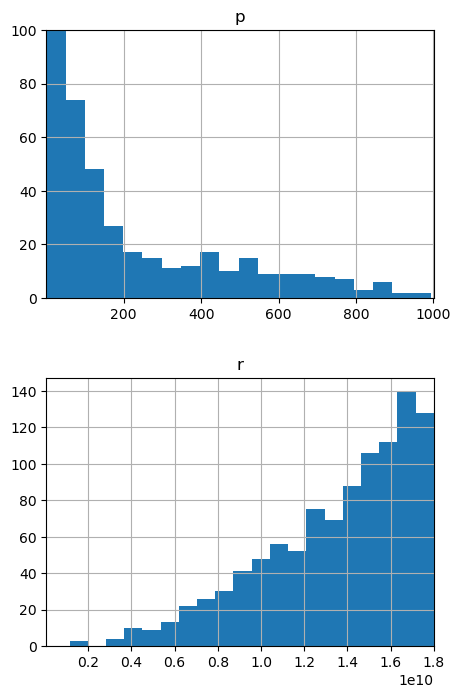

In [37]:
# Visualize
fig, axes = plt.subplots(2, figsize=(5, 8))
axes[0].set_title('p')
p.hist(ax=axes[0], bins=20)
axes[0].set_xlim(4.332436e-02, 1.00093756e+03)
axes[0].set_ylim(0, 100)

axes[1].set_title('r')
r.hist(ax=axes[1], bins=20)
axes[1].set_xlim(5.9999988e+07, 1.80000010e+10)